# Optimization with Atomic Orbital Search (AOS)

## Required Libraries

In [242]:
import time
import numpy as np
import matplotlib.pyplot as plt
from niapy.task import Task
from niapy.algorithms.basic import ArtificialBeeColonyAlgorithm
from pyswarms.utils.functions import single_obj as fx

## Atomic Orbital Search Implementation

In [338]:
# Atomic Orbital Search (AOS) Class
class AtomicOrbitalSearch:
    def __init__(self, cost_function, var_number=2, var_min=-5, var_max=5, max_fes=100000, n_pop=25, layer_number=5, foton_rate=0.1):
        self.cost_function = cost_function
        self.var_number = var_number
        self.var_min = var_min * np.ones(var_number)
        self.var_max = var_max * np.ones(var_number)
        self.max_fes = max_fes
        self.n_pop = n_pop
        self.layer_number = layer_number
        self.foton_rate = foton_rate
        
        # Initialization
        self.pop = np.random.uniform(self.var_min, self.var_max, (n_pop, var_number))
        self.cost = np.array([self.cost_function(ind) for ind in self.pop])
        self.fes = n_pop  # Function Evaluations
        self.best_pop = None
        self.best_cost = float('inf')
        self.best_costs = []
        self.iteration_candidates = []  # To store candidates for plotting

    def run(self):
        # Sort Population
        sorted_indices = np.argsort(self.cost)
        self.pop = self.pop[sorted_indices]
        self.cost = self.cost[sorted_indices]
        self.best_pop = self.pop[0]
        self.best_cost = self.cost[0]
        
        # Main Loop
        iter = 0
        while self.fes < self.max_fes:
            iter += 1
            pop_c = []
            cost_c = []
            self.iteration_candidates.append(np.copy(self.pop))  # Store current candidates
            
            # Create Quantum Layers
            max_lay = np.random.randint(1, self.layer_number + 1)
            nor_disp = np.exp(-np.arange(max_lay) / (max_lay / 6))
            nor_disp /= np.sum(nor_disp)  # Normalize
            nor_disp_cal = np.round(nor_disp * self.n_pop).astype(int)
            lay_col = np.concatenate(([0], np.cumsum(nor_disp_cal)))  # límites de las capas
            lay_col[lay_col > self.n_pop] = self.n_pop  # asegura de que no exceda la población total
            
            # Search Loop
            for i in range(max_lay):
                pop_a = self.pop[lay_col[i]:lay_col[i + 1]]  # soluciones que pertenecen a la capa i
                cost_a = self.cost[lay_col[i]:lay_col[i + 1]]  # coste de soluciones de la capa i
                energy = np.mean(cost_a)  # energía promedio de la capa i
                orbit = i + 1  # Layer index (starting from 1)

                for j in range(len(pop_a)):  # para cada solución (electrón) de la capa i
                    if np.random.rand() > self.foton_rate:  # interacción con fotones
                        if cost_a[j] > energy:
                            ir = np.random.rand(2)
                            jr = np.random.rand(self.var_number)
                            x_old = pop_a[j]
                            x_best = self.best_pop
                            x_mean = np.mean(pop_a, axis=0) if len(pop_a) > 1 else pop_a[0]
                            pop_b = x_old + (jr * (ir[0] * x_best - ir[1] * x_mean) / orbit)
                        else:
                            ir = np.random.rand(2)
                            jr = np.random.rand(self.var_number)
                            x_old = pop_a[j]
                            x_best = pop_a[0]
                            x_mean = np.mean(pop_a, axis=0) if len(pop_a) > 1 else pop_a[0]
                            pop_b = x_old + (jr * (ir[0] * x_best - ir[1] * x_mean))
                    else:
                        pop_b = np.random.uniform(self.var_min, self.var_max, self.var_number)

                    # Apply bounds
                    pop_b = np.clip(pop_b, self.var_min, self.var_max)
                    cost_b = self.cost_function(pop_b)
                    self.fes += 1
                    
                    # Store results
                    pop_c.append(pop_b)
                    cost_c.append(cost_b)

            # Merge Candidates
            self.pop = np.vstack((self.pop, pop_c))
            self.cost = np.concatenate((self.cost, cost_c))

            # Sort Population
            sorted_indices = np.argsort(self.cost)
            self.pop = self.pop[sorted_indices]
            self.cost = self.cost[sorted_indices]
            self.best_pop = self.pop[0]
            self.best_cost = self.cost[0]
            self.best_costs.append(self.best_cost)

            # Truncate population
            self.pop = self.pop[:self.n_pop]
            self.cost = self.cost[:self.n_pop]

            # Show Iteration Information
            # print(f"Iteration {iter}: Best Cost = {self.best_cost}")

        return self.best_pop, self.best_cost, self.best_costs

# Plotting convergence
def plot_convergence(best_costs):
    plt.figure(figsize=(10, 6))
    plt.plot(best_costs, color='blue', linewidth=2)
    plt.title('Convergence Plot')
    plt.xlabel('Iteration')
    plt.ylabel('Best Cost')
    plt.grid(True)
    plt.show()

## Test functions

In [264]:
def test_functions(X, fun_index, dim=None):
    if dim is None:
        dim = len(X)
        
    if fun_index == 1:  # Sphere
        Fit = np.sum(X ** 2)

    elif fun_index == 2:  # Schwefel 1.2
        Fit = sum([np.sum(X[:i + 1]) ** 2 for i in range(dim)])

    elif fun_index == 3:  # Schwefel 2.21
        Fit = np.max(np.abs(X))

    elif fun_index == 4:  # Rosenbrock
        Fit = np.sum(100 * (X[1:] - X[:-1] ** 2) ** 2 + (X[:-1] - 1) ** 2)

    elif fun_index == 5:  # Quartic
        Fit = np.sum(np.arange(1, dim + 1) * (X ** 4)) + np.random.rand()

    elif fun_index == 6:  # Schwefel
        Fit = np.sum(-X * np.sin(np.sqrt(np.abs(X))))

    elif fun_index == 7:  # Rastrigin
        Fit = np.sum(X ** 2 - 10 * np.cos(2 * np.pi * X)) + 10 * dim

    elif fun_index == 8:  # Ackley
        Fit = -20 * np.exp(-0.2 * np.sqrt(np.sum(X ** 2) / dim)) - \
              np.exp(np.sum(np.cos(2 * np.pi * X)) / dim) + 20 + np.e

    elif fun_index == 9:  # Hartman 3
        a = np.array([[3, 10, 30], [0.1, 10, 35], [3, 10, 30], [0.1, 10, 35]])
        c = np.array([1, 1.2, 3, 3.2])
        p = np.array([[0.3689, 0.117, 0.2673], [0.4699, 0.4387, 0.747], [0.1091, 0.8732, 0.5547], [0.03815, 0.5743, 0.8828]])
        Fit = -np.sum([c[i] * np.exp(-np.sum(a[i, :] * (X - p[i, :]) ** 2)) for i in range(4)])

    elif fun_index == 10:  # Hartman 6
        a = np.array([[10, 3, 17, 3.5, 1.7, 8], [0.05, 10, 17, 0.1, 8, 14], [3, 3.5, 1.7, 10, 17, 8],
                    [17, 8, 0.05, 10, 0.1, 14]])
        c = np.array([1, 1.2, 3, 3.2])
        p = np.array([[0.1312, 0.1696, 0.5569, 0.0124, 0.8283, 0.5886],
                    [0.2329, 0.4135, 0.8307, 0.3736, 0.1004, 0.9991],
                    [0.2348, 0.1415, 0.3522, 0.2883, 0.3047, 0.6650],
                    [0.4047, 0.8828, 0.8732, 0.5743, 0.1091, 0.0381]])
        Fit = -np.sum([c[i] * np.exp(-np.sum(a[i, :] * (X - p[i, :]) ** 2)) for i in range(4)])

    elif fun_index == 11:  # Shekel 5, 7, 10
        a = np.array([[4, 4, 4, 4], [1, 1, 1, 1], [8, 8, 8, 8], [6, 6, 6, 6],
                    [3, 7, 3, 7], [2, 9, 2, 9], [5, 5, 3, 3], [8, 1, 8, 1],
                    [6, 2, 6, 2], [7, 3.6, 7, 3.6]])
        c = np.array([0.1, 0.2, 0.2, 0.4, 0.4, 0.6, 0.3, 0.7, 0.5, 0.5])
        m = 5 if fun_index == 21 else (7 if fun_index == 22 else 10)
        Fit = -np.sum([1 / (np.sum((X - a[i, :]) ** 2) + c[i]) for i in range(m)])

    else:
        raise ValueError("Invalid function index.")

    return Fit

def test_functions_pso(X, fun_index):
    """
    Compute the fitness values for a batch of input vectors `X`.

    Parameters:
    - X: ndarray of shape (n_particles, dimensions), where each row is a particle.
    - fun_index: int, Index of the benchmark function to evaluate.

    Returns:
    - fitness_values: ndarray of shape (n_particles,), Fitness values for each particle.
    """
    n_particles, dim = X.shape

    if fun_index == 1:  # Sphere
        fitness_values = np.sum(X ** 2, axis=1)

    elif fun_index == 2:  # Schwefel 1.2
        fitness_values = np.array([
            np.sum([np.sum(x[:i + 1]) ** 2 for i in range(dim)])
            for x in X
        ])

    elif fun_index == 3:  # Schwefel 2.21
        fitness_values = np.max(np.abs(X), axis=1)

    elif fun_index == 4:  # Rosenbrock
        fitness_values = np.sum(
            100 * (X[:, 1:] - X[:, :-1] ** 2) ** 2 + (X[:, :-1] - 1) ** 2,
            axis=1,
        )

    elif fun_index == 5:  # Quartic
        fitness_values = np.sum(
            np.arange(1, dim + 1) * (X ** 4), axis=1
        ) + np.random.rand(n_particles)

    elif fun_index == 6:  # Schwefel
        fitness_values = np.sum(-X * np.sin(np.sqrt(np.abs(X))), axis=1)

    elif fun_index == 7:  # Rastrigin
        fitness_values = np.sum(
            X ** 2 - 10 * np.cos(2 * np.pi * X), axis=1
        ) + 10 * dim

    elif fun_index == 8:  # Ackley
        fitness_values = -20 * np.exp(
            -0.2 * np.sqrt(np.sum(X ** 2, axis=1) / dim)
        ) - np.exp(np.sum(np.cos(2 * np.pi * X), axis=1) / dim) + 20 + np.e

    elif fun_index == 9:  # Hartman 3
        a = np.array([[3, 10, 30], [0.1, 10, 35], [3, 10, 30], [0.1, 10, 35]])
        c = np.array([1, 1.2, 3, 3.2])
        p = np.array([[0.3689, 0.117, 0.2673], [0.4699, 0.4387, 0.747], [0.1091, 0.8732, 0.5547], [0.03815, 0.5743, 0.8828]])
        fitness_values = np.array([
            -np.sum([c[i] * np.exp(-np.sum(a[i, :] * (x - p[i, :]) ** 2)) for i in range(4)])
            for x in X
        ])

    elif fun_index == 10:  # Hartman 6
        a = np.array([[10, 3, 17, 3.5, 1.7, 8], [0.05, 10, 17, 0.1, 8, 14], [3, 3.5, 1.7, 10, 17, 8],
                      [17, 8, 0.05, 10, 0.1, 14]])
        c = np.array([1, 1.2, 3, 3.2])
        p = np.array([[0.1312, 0.1696, 0.5569, 0.0124, 0.8283, 0.5886],
                      [0.2329, 0.4135, 0.8307, 0.3736, 0.1004, 0.9991],
                      [0.2348, 0.1415, 0.3522, 0.2883, 0.3047, 0.6650],
                      [0.4047, 0.8828, 0.8732, 0.5743, 0.1091, 0.0381]])
        fitness_values = np.array([
            -np.sum([c[i] * np.exp(-np.sum(a[i, :] * (x - p[i, :]) ** 2)) for i in range(4)])
            for x in X
        ])

    elif fun_index == 11:  # Shekel 5, 7, 10
        a = np.array([[4, 4, 4, 4], [1, 1, 1, 1], [8, 8, 8, 8], [6, 6, 6, 6],
                      [3, 7, 3, 7], [2, 9, 2, 9], [5, 5, 3, 3], [8, 1, 8, 1],
                      [6, 2, 6, 2], [7, 3.6, 7, 3.6]])
        c = np.array([0.1, 0.2, 0.2, 0.4, 0.4, 0.6, 0.3, 0.7, 0.5, 0.5])
        m = 5 if fun_index == 21 else (7 if fun_index == 22 else 10)
        fitness_values = np.array([
            -np.sum([1 / (np.sum((x - a[i, :]) ** 2) + c[i]) for i in range(m)])
            for x in X
        ])

    else:
        raise ValueError("Invalid function index.")

    return fitness_values


def test_functions_range(fun_index):
    """
    Get the range and default dimension for a given benchmark function index.

    Parameters:
    - fun_index: int, Index of the function

    Returns:
    - low: float or ndarray, Lower bound(s) of the input space
    - up: float or ndarray, Upper bound(s) of the input space
    - dim: int, Default dimension
    """
    dim = 2  # Default dimension
    if fun_index == 1:
        low, up = -100, 100
    elif fun_index == 2:
        low, up = -100, 100
    elif fun_index == 3:
        low, up = -100, 100
    elif fun_index == 4:
        low, up = -30, 30
    elif fun_index == 5:
        low, up = -1.28, 1.28
    elif fun_index == 6:
        low, up = -500, 500
    elif fun_index == 7:
        low, up = -5.12, 5.12
    elif fun_index == 8:
        low, up = -32, 32
    elif fun_index == 9:
        low, up = 0, 1
        dim = 3
    elif fun_index == 10:
        low, up = 0, 1
        dim = 6
    elif fun_index == 11:
        low, up = 0, 10
        dim = 4
    else:
        low, up = 0, 10
        dim = 4

    return low, up, dim


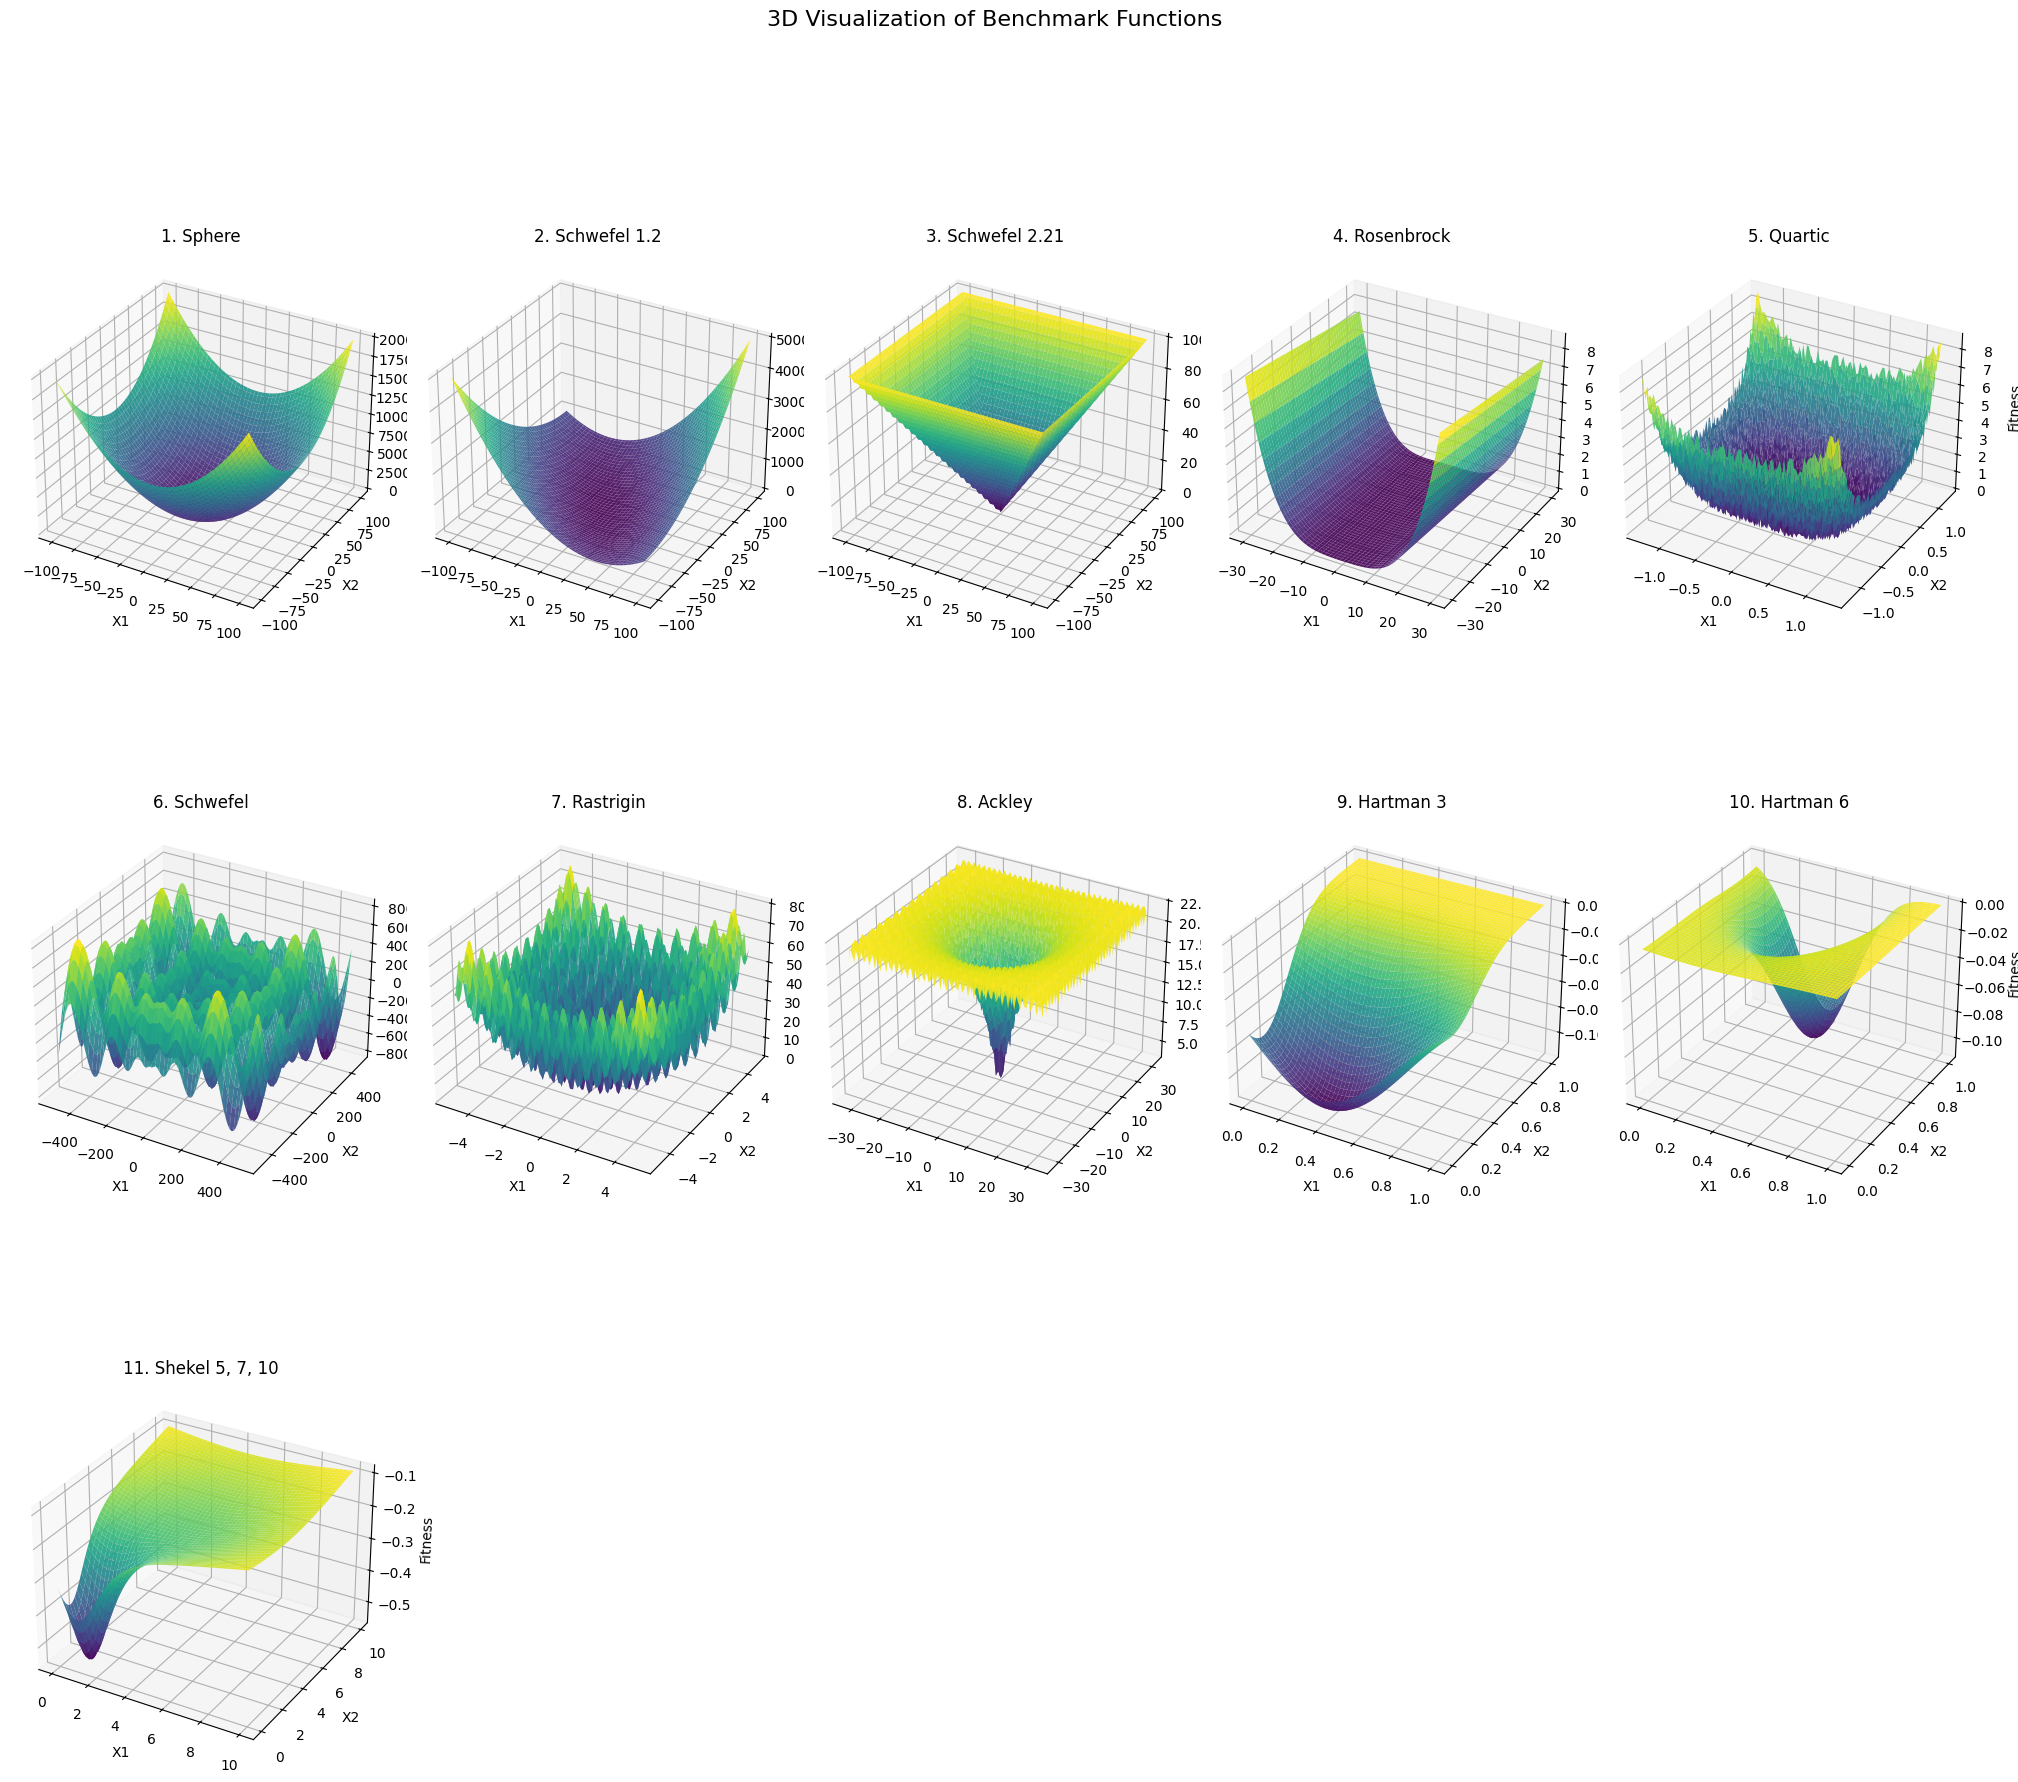

In [334]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

function_names = ["1. Sphere", "2. Schwefel 1.2", "3. Schwefel 2.21", "4. Rosenbrock",
                    "5. Quartic", "6. Schwefel", "7. Rastrigin", "8. Ackley", "9. Hartman 3",
                    "10. Hartman 6", "11. Shekel 5, 7, 10"]


def plot_functions_in_3d():
    num_functions = 11  # Total number of functions
    rows, cols = 3,5   # Arrange plots in a grid (adjust rows/cols to fit all functions)
    
    fig = plt.figure(figsize=(20, 20))
    fig.suptitle("3D Visualization of Benchmark Functions", fontsize=16)
    
    for fun_index in range(1, num_functions + 1):
        # Compute subplot position
        ax = fig.add_subplot(rows, cols, fun_index, projection='3d')
        
        # Get range and default dimension for this function
        low, up, dim = test_functions_range(fun_index)
        
        # Set up 2D grid (for visualization, we use the first two dimensions)
        x = np.linspace(low[0] if isinstance(low, np.ndarray) else low,
                        up[0] if isinstance(up, np.ndarray) else up, 100)
        y = np.linspace(low[1] if isinstance(low, np.ndarray) and len(low) > 1 else low,
                        up[1] if isinstance(up, np.ndarray) and len(up) > 1 else up, 100)
        X, Y = np.meshgrid(x, y)
        
        # Flatten grid and prepare inputs for the function
        Z = np.zeros_like(X)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                point = np.zeros(dim)
                point[0] = X[i, j]
                if dim > 1:
                    point[1] = Y[i, j]
                Z[i, j] = test_functions(point, fun_index, dim)
        
        # Plot the 3D surface
        surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.9)
        ax.set_title(f"{function_names[fun_index - 1]}")
        ax.set_xlabel("X1")
        ax.set_ylabel("X2")
        ax.set_zlabel("Fitness")
        #fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Call the 3D plotting function
plot_functions_in_3d()


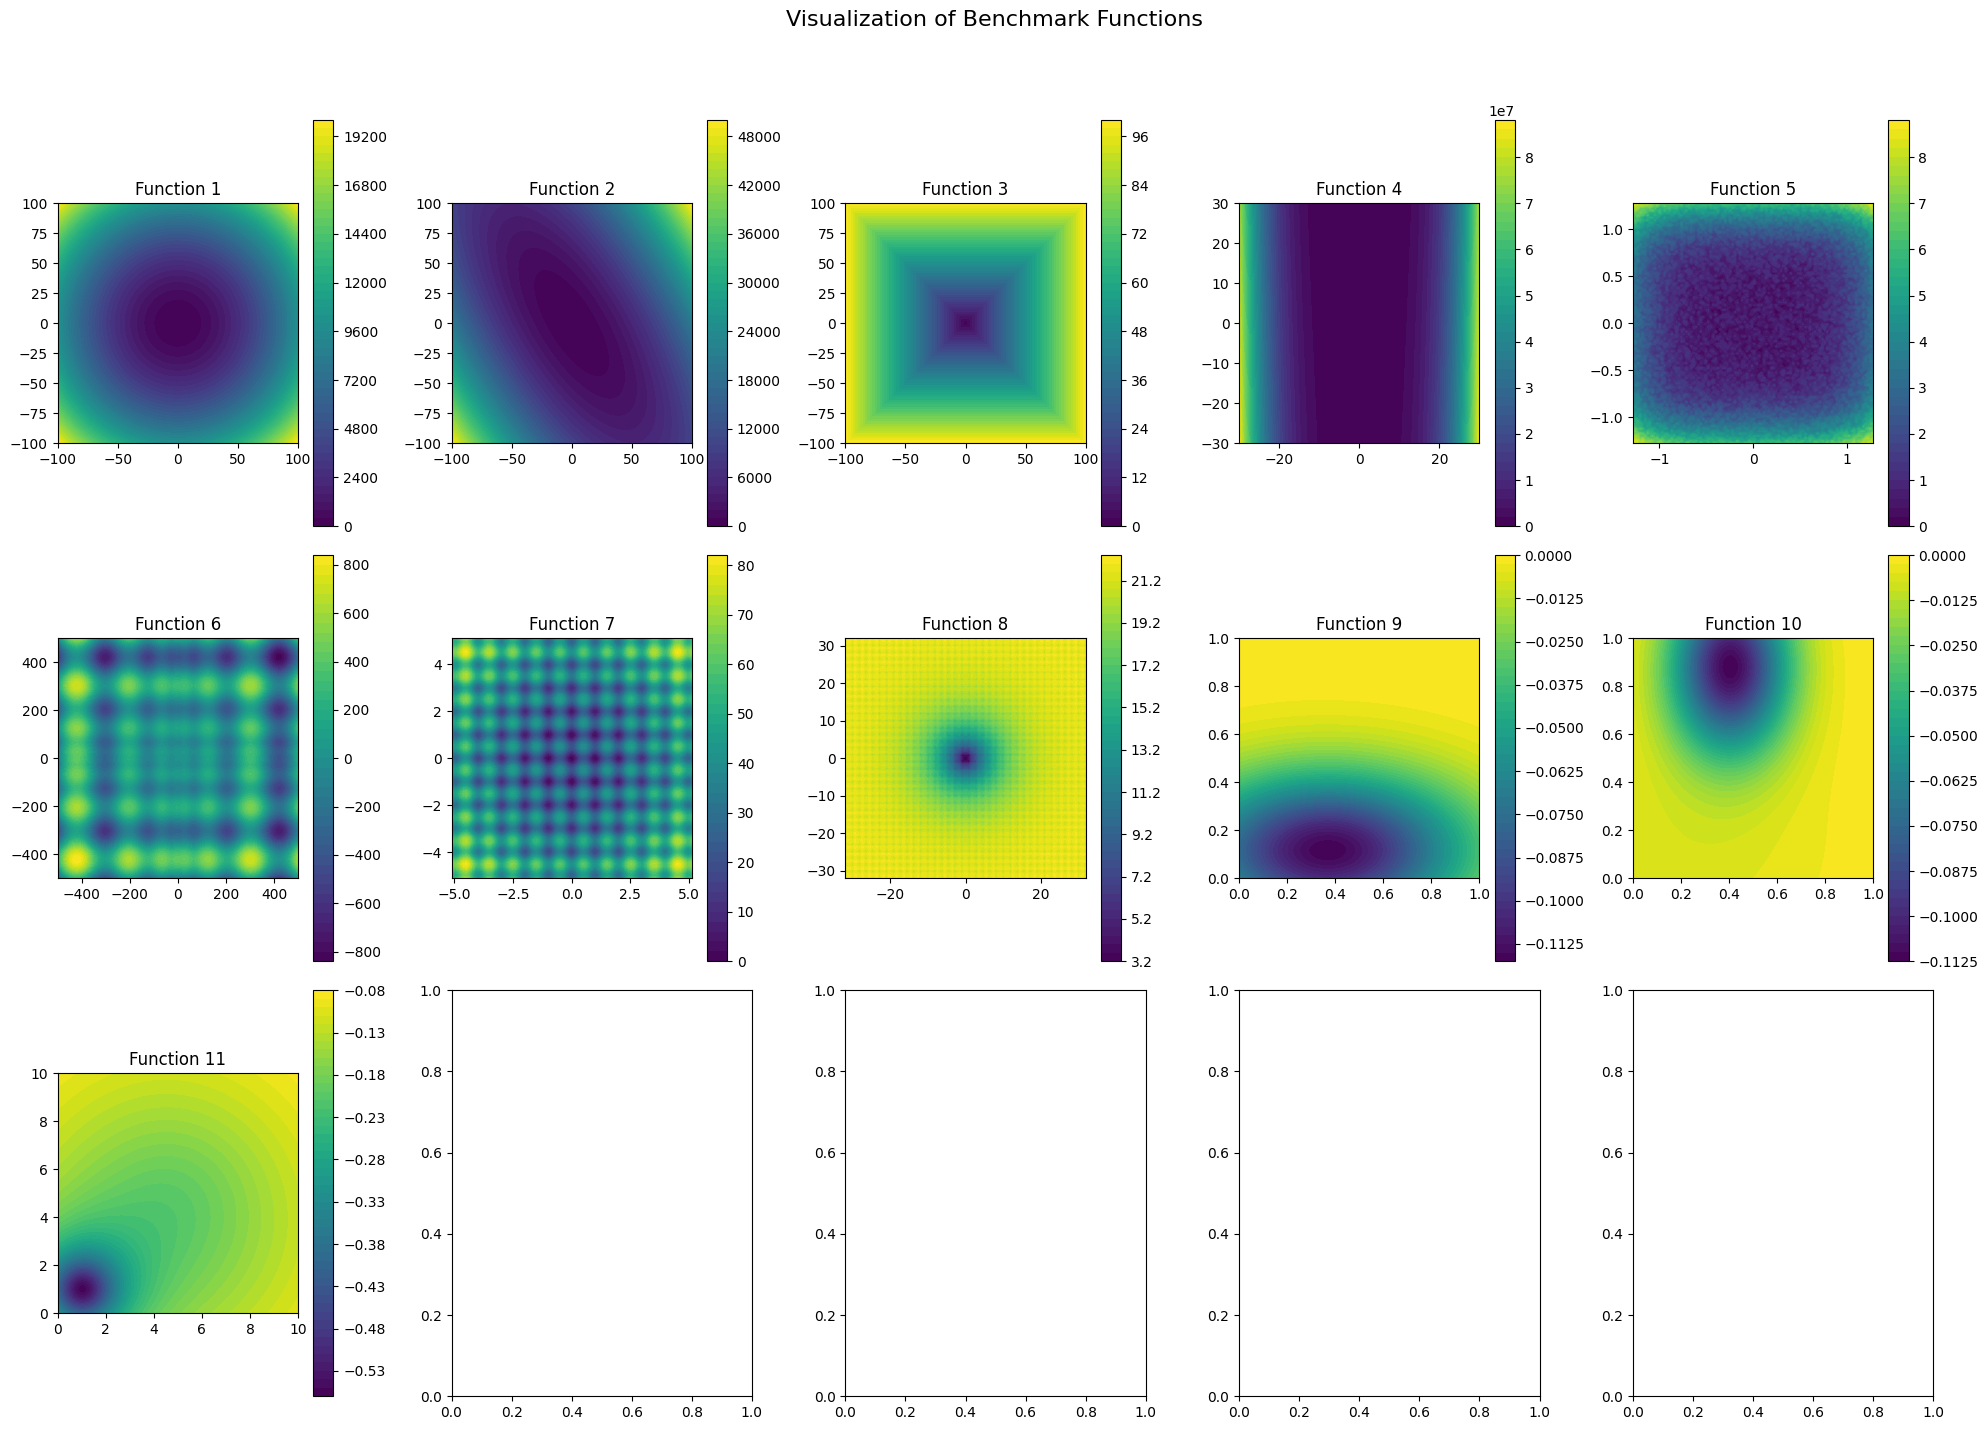

In [246]:
def plot_functions_in_grid():
    num_functions = 11  # Total number of functions
    rows, cols = 3, 5   # Arrange plots in a grid (adjust rows/cols to fit all functions)
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
    fig.suptitle("Visualization of Benchmark Functions", fontsize=16)
    
    for fun_index in range(1, num_functions + 1):
        row, col = divmod(fun_index - 1, cols)  # Compute subplot position
        ax = axes[row, col]
        
        # Get range and default dimension for this function
        low, up, dim = test_functions_range(fun_index)
        
        # Set up 2D grid (for visualization, we use the first two dimensions)
        x = np.linspace(low[0] if isinstance(low, np.ndarray) else low,
                        up[0] if isinstance(up, np.ndarray) else up, 100)
        y = np.linspace(low[1] if isinstance(low, np.ndarray) and len(low) > 1 else low,
                        up[1] if isinstance(up, np.ndarray) and len(up) > 1 else up, 100)
        X, Y = np.meshgrid(x, y)
        
        # Flatten grid and prepare inputs for the function
        Z = np.zeros_like(X)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                point = np.zeros(dim)
                point[0] = X[i, j]
                if dim > 1:
                    point[1] = Y[i, j]
                Z[i, j] = test_functions(point, fun_index, dim)
        
        # Plot the function
        c = ax.contourf(X, Y, Z, levels=50, cmap='viridis')
        ax.set_title(f"Function {fun_index}")
        ax.set_aspect('equal')  # Set aspect ratio to be equal
        fig.colorbar(c, ax=ax, orientation='vertical')
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Call the plotting function
plot_functions_in_grid()


In [247]:
import numpy as np

def select_test_function(fun_index):
    """
    Selects a test function and its parameter ranges by index.
    """
    low, up, dim = test_functions_range(fun_index)

    def function(X):
        return test_functions(X, fun_index)

    return function, low, up, dim


## Parameter optimization using ABC

### AOS

In [335]:
def aos_objective(params, fun_index):
    """
    Objective function to evaluate AOS performance with given parameters.

    Parameters:
    - params: List of AOS parameters [n_pop, layer_number, foton_rate].

    Returns:
    - best_cost: The best cost achieved by AOS with the given parameters.
    """
    n_pop = int(params[0])        # Population size
    layer_number = int(params[1]) # Number of quantum layers
    foton_rate = params[2]        # Photon interaction rate

    # Test function setup
    function, var_min, var_max, var_number = select_test_function(fun_index)

    # Instantiate and run AOS
    aos = AtomicOrbitalSearch(
        cost_function=function,
        var_number=var_number,
        var_min=var_min,
        var_max=var_max,
        max_fes=10000,
        n_pop=n_pop,
        layer_number=layer_number,
        foton_rate=foton_rate
    )
    _, best_cost, _ = aos.run()

    return best_cost  # Return the best cost as the objective value


In [336]:
from niapy.task import Task
from niapy.problems import Problem
from niapy.algorithms.basic import ArtificialBeeColonyAlgorithm

# Define the problem class for AOS parameter optimization
class AOSParamOptimization(Problem):
    def __init__(self, fun_index):
        # Define the dimension (3 parameters: n_pop, layer_number, foton_rate)
        # and bounds for each parameter
        super().__init__(dimension=3, lower=[10, 1, 0.01], upper=[100, 10, 0.5])
        self.fun_index = fun_index

    def _evaluate(self, x):
        # Call the AOS objective function
        return aos_objective(x, self.fun_index)
    
fun_index = 7  # Select the benchmark function to optimize

# Create a task for the ABC algorithm
task = Task(problem=AOSParamOptimization(fun_index), max_evals=50)  # Set maximum evaluations

# Initialize and run the ABC algorithm
abc = ArtificialBeeColonyAlgorithm(population_size=20)
best_params_aos, best_cost_aos = abc.run(task=task)

print(f"Optimized Parameters: {best_params_aos}")
print(f"Best Cost Achieved: {best_cost_aos}")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Optimized Parameters: [82.40488264  4.25451565  0.22663317]
Best Cost Achieved: 0.0


Validated Best Cost: 0.0


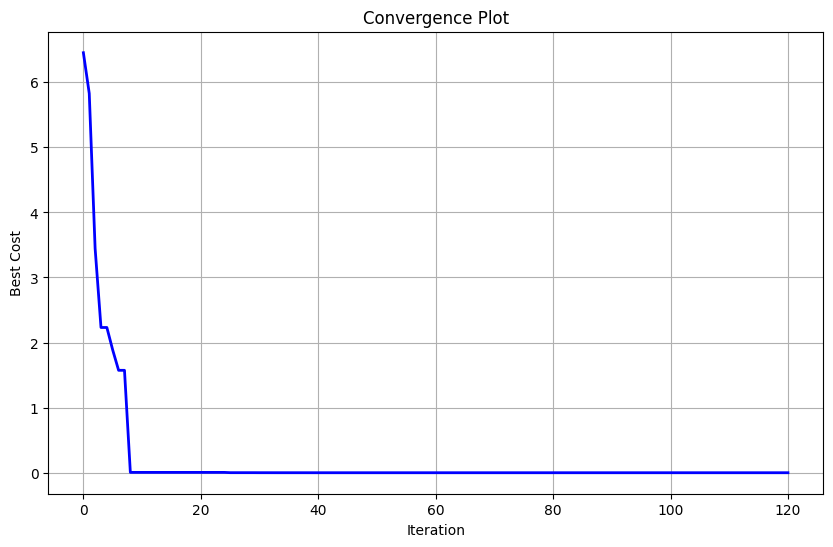

In [347]:
n_pop, layer_number, foton_rate = int(best_params_aos[0]), int(best_params_aos[1]), best_params_aos[2]
# Validate AOS with optimized parameters
function, var_min, var_max, var_number = select_test_function(fun_index)
aos = AtomicOrbitalSearch(
    cost_function=function,
    var_number=var_number,
    var_min=var_min,
    var_max=var_max,
    max_fes=10000,
    n_pop=n_pop,
    layer_number=layer_number,
    foton_rate=foton_rate
)
best_solution_aos, best_cost_aos, best_costs_aos = aos.run()

print(f"Validated Best Cost: {best_cost_aos}")
plot_convergence(best_costs_aos)  # Plot convergence if needed



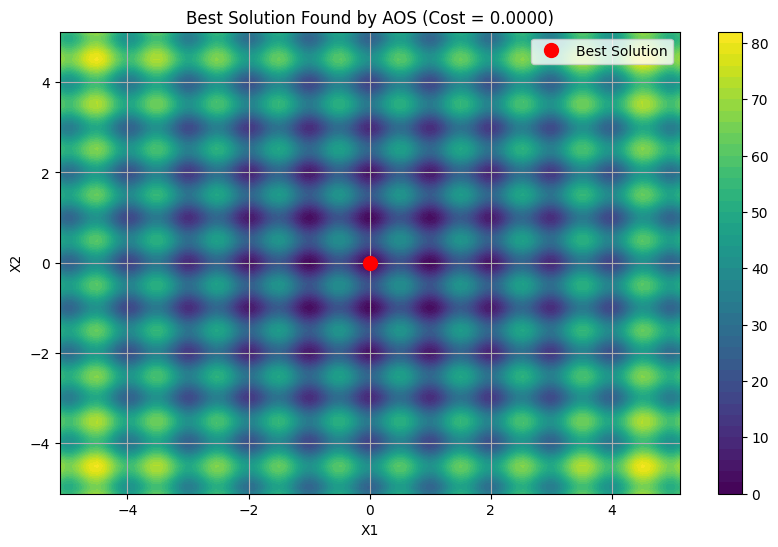

In [340]:
# Show the best solution found by AOS in a 2D plot
def plot_solution_2d(best_solution, best_cost):
    # Get the test function and its parameter ranges
    function, var_min, var_max, var_number = select_test_function(fun_index)
    
    # Convert var_min and var_max to arrays
    var_min = np.array([var_min] * var_number)
    var_max = np.array([var_max] * var_number)
    
    # Set up 2D grid for plotting
    x = np.linspace(var_min[0], var_max[0], 100)
    y = np.linspace(var_min[1], var_max[1], 100)
    X, Y = np.meshgrid(x, y)
    
    # Compute the function values for the grid
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            point = np.array([X[i, j], Y[i, j]])
            Z[i, j] = function(point)
    
    # Plot the function and the best solution
    plt.figure(figsize=(10, 6))
    plt.contourf(X, Y, Z, levels=50, cmap='viridis')
    plt.plot(best_solution[0], best_solution[1], 'ro', markersize=10, label='Best Solution')
    plt.title(f'Best Solution Found by AOS (Cost = {best_cost:.4f})')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.colorbar()
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the 2D plotting function
plot_solution_2d(best_solution_aos, best_cost_aos)

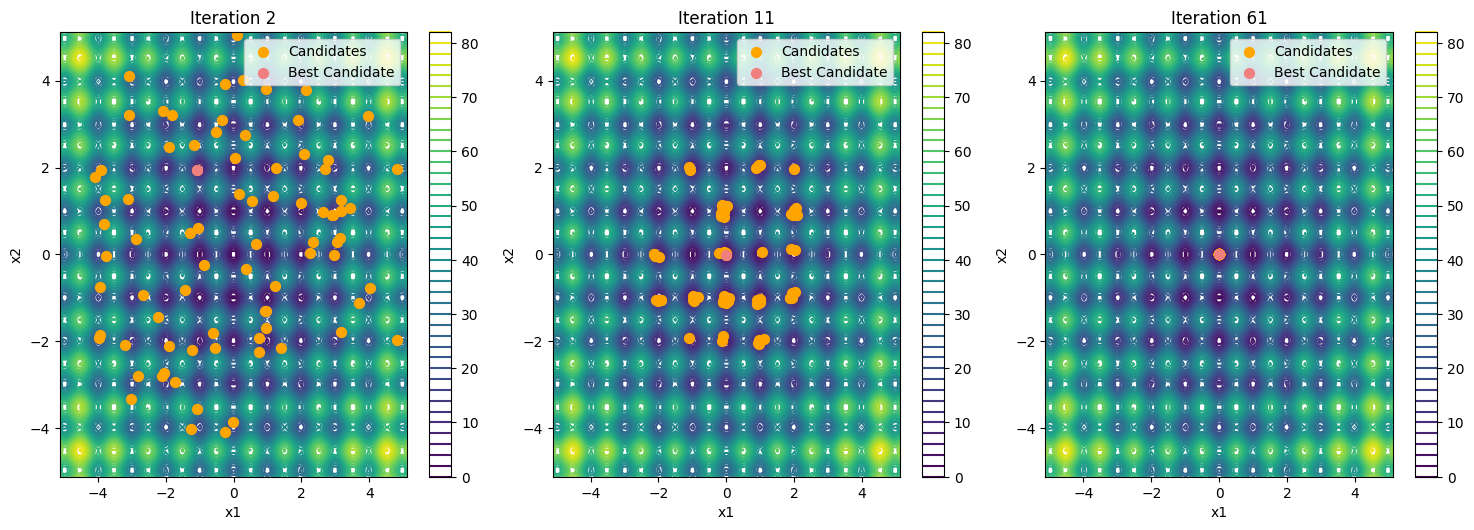

In [362]:
# Plotting the Evolution of Candidates
def plot_candidate_evolution(aos, num_plots=6):
    plt.figure(figsize=(15, 10))
    num_iterations = len(aos.iteration_candidates)
    selected_iterations = [1, 10, 60]
    
    # Get the test function and its parameter ranges
    function, var_min, var_max, var_number = select_test_function(fun_index)
    
    # Set up 2D grid for plotting
    x = np.linspace(var_min, var_max, 100)
    y = np.linspace(var_min, var_max, 100)
    X, Y = np.meshgrid(x, y)
    
    # Compute the function values for the grid
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            point = np.array([X[i, j], Y[i, j]])
            Z[i, j] = function(point)
    
    for i, iter_idx in enumerate(selected_iterations):
        plt.subplot(2, 3, i + 1)
        
        # Plot the contour first with a lower zorder
        plt.contour(X, Y, Z, levels=50, cmap='viridis', zorder=1)
        plt.colorbar()
        plt.title(f'Iteration {iter_idx + 1}')
        plt.xlabel('x1')
        plt.ylabel('x2')

        # Plot candidates with a higher zorder
        candidates = aos.iteration_candidates[iter_idx]
        plt.scatter(candidates[:, 0], candidates[:, 1], color='orange', s=50, label='Candidates', marker='o', zorder=2)

        # Highlight the best candidate with the highest zorder
        best_candidate = aos.iteration_candidates[iter_idx][np.argmin([aos.cost_function(cand) for cand in candidates])]
        plt.scatter(best_candidate[0], best_candidate[1], color='lightcoral', s=50, label='Best Candidate', zorder=3)
        
        plt.legend()

    plt.tight_layout()
    plt.show()


# Call the plotting function
plot_candidate_evolution(aos, num_plots=3)

### PSO

In [252]:
from niapy.problems import Problem
from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.utils.functions import single_obj as fx

In [283]:
def select_test_function_pso(fun_index):
    """
    Selects a test function and its parameter ranges by index.
    """
    low, up, dim = test_functions_range(fun_index)

    def function(X):
        return test_functions_pso(X, fun_index)

    return function, low, up, dim

In [284]:
def pso_objective(params, fun_index, iters=100):
    """
    Objective function to evaluate PSO performance with given parameters.
    """
    n_particles = max(5, int(params[0]))  # Ensure minimum 5 particles
    cognitive = params[1]
    social = params[2]
    inertia = params[3]

    function, var_min, var_max, var_number = select_test_function_pso(fun_index)

    var_min = np.full(var_number, var_min) if np.isscalar(var_min) else var_min
    var_max = np.full(var_number, var_max) if np.isscalar(var_max) else var_max

    optimizer = GlobalBestPSO(
        n_particles=n_particles,
        dimensions=var_number,
        options={'c1': cognitive, 'c2': social, 'w': inertia},
        bounds=(var_min, var_max),
    )

    best_cost, _ = optimizer.optimize(function, iters=iters, verbose=False)
    return best_cost

In [285]:
class PSOParamOptimization(Problem):
    def __init__(self, fun_index):
        super().__init__(dimension=4, lower=[5, 0.0, 0.0, 0.1], upper=[200, 2.0, 2.0, 1.5])
        self.fun_index = fun_index

    def _evaluate(self, x):
        return pso_objective(x, self.fun_index)

fun_index = 7
task_pso = Task(problem=PSOParamOptimization(fun_index), max_evals=50)

abc_pso = ArtificialBeeColonyAlgorithm(population_size=20)
best_params_pso, best_cost_pso = abc_pso.run(task=task_pso)

print(f"Optimized PSO Parameters:")
print(f"  - Number of Particles: {int(best_params_pso[0])}")
print(f"  - Cognitive Coefficient (c1): {best_params_pso[1]:.2f}")
print(f"  - Social Coefficient (c2): {best_params_pso[2]:.2f}")
print(f"  - Inertia Weight (w): {best_params_pso[3]:.2f}")
print(f"Best Cost Achieved by PSO: {best_cost_pso:.4f}")

Optimized PSO Parameters:
  - Number of Particles: 41
  - Cognitive Coefficient (c1): 0.92
  - Social Coefficient (c2): 1.89
  - Inertia Weight (w): 0.56
Best Cost Achieved by PSO: 0.0000


Validated Best Cost: 1.7634960158829927e-10


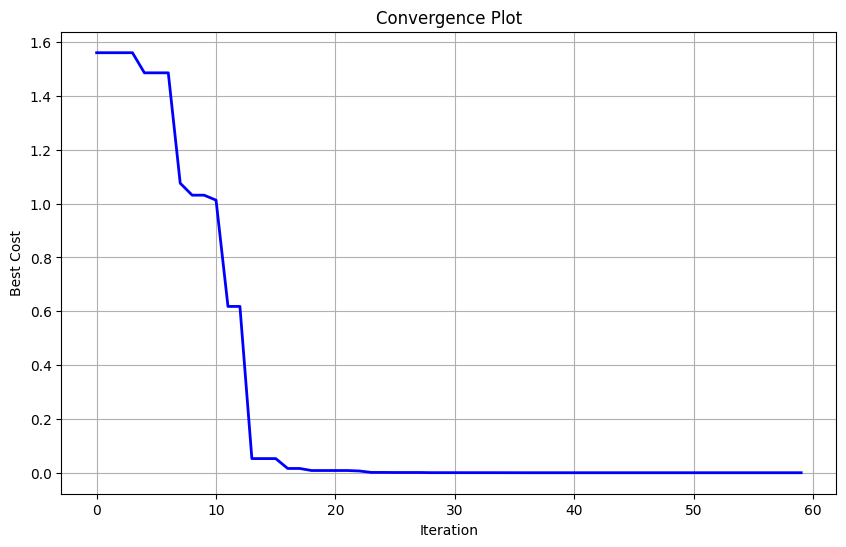

In [286]:
particles, cognitive, social, inertia = int(best_params_pso[0]), best_params_pso[1], best_params_pso[2], best_params_pso[3]
# Validate AOS with optimized parameters
function, var_min, var_max, var_number = select_test_function_pso(fun_index)

# Ensure var_min and var_max are arrays
var_min = np.full(var_number, var_min) if np.isscalar(var_min) else var_min
var_max = np.full(var_number, var_max) if np.isscalar(var_max) else var_max

pso = GlobalBestPSO(
    n_particles=particles,
    dimensions=var_number,
    options={'c1': cognitive, 'c2': social, 'w': inertia},
    bounds=(var_min, var_max),
)

best_cost_pso, best_pos_pso = pso.optimize(function, iters=60, verbose=False)

print(f"Validated Best Cost: {best_cost_pso}")
plot_convergence(pso.cost_history)  # Plot convergence if needed

/var/folders/k8/pm7rdrpx1tx44znvg04hlryc0000gn/T/ipykernel_21243/3194016839.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i, j] = function(point.reshape(1, -1))


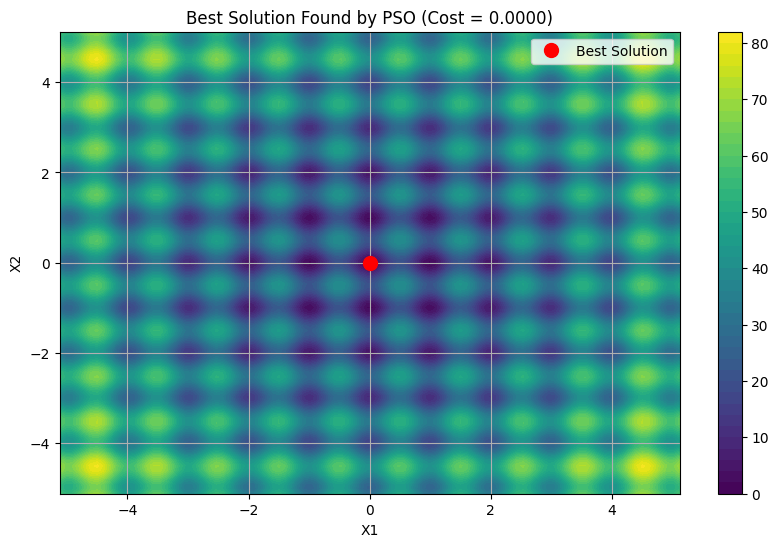

In [287]:
# Plot the best solution found by PSO in a 2D plot
fun_index = 7  # Select the benchmark function to optimize
def plot_solution_2d_pso(best_solution, best_cost):
    # Get the test function and its parameter ranges
    function, var_min, var_max, var_number = select_test_function_pso(fun_index)
    
    # Convert var_min and var_max to arrays
    var_min = np.array([var_min] * var_number)
    var_max = np.array([var_max] * var_number)
    
    # Set up 2D grid for plotting
    x = np.linspace(var_min[0], var_max[0], 100)
    y = np.linspace(var_min[1], var_max[1], 100)
    X, Y = np.meshgrid(x, y)
    
    # Compute the function values for the grid
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            point = np.array([X[i, j], Y[i, j]])
            Z[i, j] = function(point.reshape(1, -1))
    
    # Plot the function and the best solution
    plt.figure(figsize=(10, 6))
    plt.contourf(X, Y, Z, levels=50, cmap='viridis')
    plt.plot(best_solution[0], best_solution[1], 'ro', markersize=10, label='Best Solution')
    plt.title(f'Best Solution Found by PSO (Cost = {best_cost:.4f})')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.colorbar()
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the 2D plotting function for PSO
plot_solution_2d_pso(best_pos_pso, best_cost_pso)

### GA

In [258]:
from niapy.problems import Problem
from geneticalgorithm import geneticalgorithm as ga

In [259]:
def ga_objective(params, fun_index):
    """
    Objective function to evaluate GA performance with given parameters.

    Parameters:
    - params: List of GA parameters [max_num_iterations, population_size, crossover_rate, mutation_rate].

    Returns:
    - best_cost: The best cost achieved by GA with the given parameters.
    """
    max_num_iterations = int(params[0])  # Maximum number of iterations
    population_size = int(params[1])     # Population size
    crossover_rate = params[2]           # Crossover rate
    mutation_rate = params[3]            # Mutation rate

    # Test function setup
    function, var_min, var_max, var_number = select_test_function(fun_index)

    # Set GA algorithm parameters
    varbound = np.array([[var_min, var_max]] * var_number)  # Bounds for each parameter
    algorithm_params = {
        "max_num_iteration": max_num_iterations,
        "population_size": population_size,
        "mutation_probability": mutation_rate,
        "elit_ratio": 0.01,
        "crossover_probability": crossover_rate,
        "parents_portion": 0.3,
        "crossover_type": "uniform",
        "max_iteration_without_improv": None
    }
    
    # Initialize the GA algorithm
    ga_model = ga(
        function=function,
        dimension=var_number,
        variable_type='real',
        variable_boundaries=varbound,
        algorithm_parameters=algorithm_params,
        convergence_curve=False,  # Suppress convergence curve
        progress_bar=False
    )
    
    # Temporarily redirect stdout to suppress all output
    ga_model.run()

    # Get the best cost
    best_cost = ga_model.output_dict['function']  # Extract the best cost
    return best_cost  # Return the best cost as the objective value

In [260]:
class GAParamOptimization(Problem):
    def __init__(self, fun_index):
        # Define the dimension (3 parameters: max_num_iteration, population_size, crossover_rate, mutation_rate)
        super().__init__(dimension=4, lower=[10, 10, 0.1, 0.1], upper=[100, 100, 1.0, 1.0])
        self.fun_index = fun_index

    def _evaluate(self, x):
        # Call the GA objective function
        return ga_objective(x, self.fun_index)
    
# Create a task for the GA parameter optimization
task_ga = Task(problem=GAParamOptimization(fun_index), max_evals=50)  # Set maximum evaluations

# Initialize and run the ABC algorithm for GA
abc_ga = ArtificialBeeColonyAlgorithm(population_size=10)
best_params_ga, best_cost_ga = abc_ga.run(task=task_ga)

print(f"Optimized GA Parameters: {best_params_ga}")
print(f"Best Cost Achieved by GA: {best_cost_ga}")

 The best solution found:
 [-4.51991751e-04 -1.15233346e-05]

 Objective function:
 4.055713458939181e-05
 The best solution found:
 [0.00023801 0.03838786]

 Objective function:
 0.2909598497068018
 The best solution found:
 [-0.00805923 -0.01813497]

 Objective function:
 0.07805950407055917
 The best solution found:
 [-0.01576386  0.0203894 ]

 Objective function:
 0.1316251168404463
 The best solution found:
 [-0.00342157  0.00600652]

 Objective function:
 0.009479316546183725
 The best solution found:
 [ 0.00482432 -0.99419893]

 Objective function:
 0.9996905385915618
 The best solution found:
 [0.97794798 0.02575268]

 Objective function:
 1.183507289076914
 The best solution found:
 [-0.03006188  0.00283715]

 Objective function:
 0.18035737771226934
 The best solution found:
 [-0.00533985 -0.00787573]

 Objective function:
 0.017959615905695614
 The best solution found:
 [-0.00178994 -0.00553997]

 Objective function:
 0.006723917580806926
 The best solution found:
 [-0.00306

 The best solution found:
 [-0.00275289 -0.00030254]

 Objective function:
 0.0015216149225310005


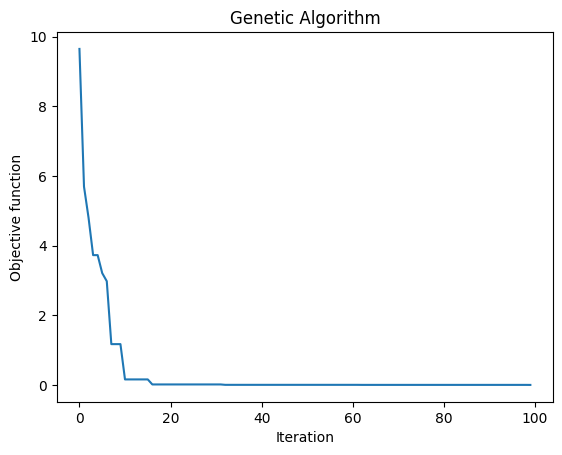

Validated Best Cost: 0.0015216149225310005


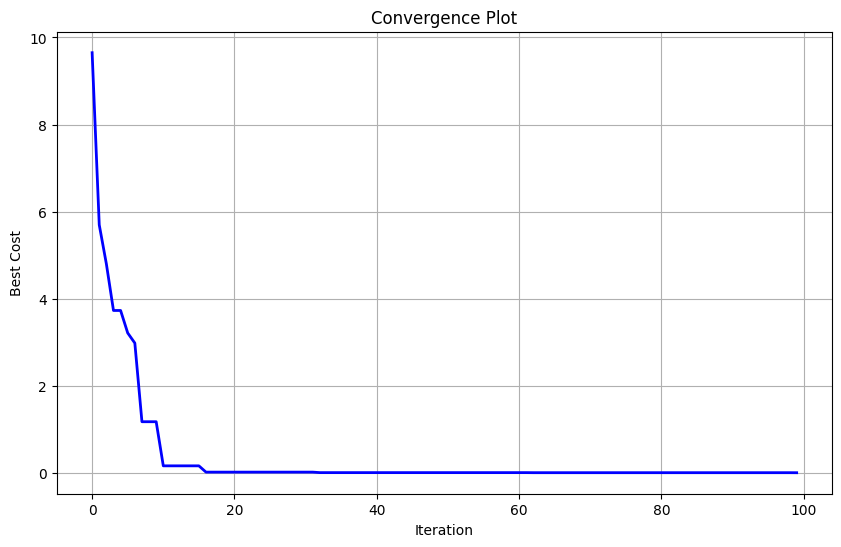

In [261]:
max_num_iterations, population_size, crossover_rate, mutation_rate = int(best_params_ga[0]), int(best_params_ga[1]), best_params_ga[2], best_params_ga[3]
# Validate AOS with optimized parameters
function, var_min, var_max, var_number = select_test_function(fun_index)
# Set GA algorithm parameters
varbound = np.array([[var_min, var_max]] * var_number)  # Bounds for each parameter
algorithm_params = {
    "max_num_iteration": max_num_iterations,
    "population_size": population_size,
    "mutation_probability": mutation_rate,
    "elit_ratio": 0.01,
    "crossover_probability": crossover_rate,
    "parents_portion": 0.3,
    "crossover_type": "uniform",
    "max_iteration_without_improv": None
}

# Initialize the GA algorithm
ga_model = ga(
    function=function,
    dimension=var_number,
    variable_type='real',
    variable_boundaries=varbound,
    algorithm_parameters=algorithm_params,
    convergence_curve=True,  # Store convergence curve
    progress_bar=False
)

# Run the GA algorithm
ga_model.run()

best_cost_ga = ga_model.output_dict['function']  # Extract the best cost
best_solution_ga = ga_model.output_dict['variable']  # Extract the best solution

print(f"Validated Best Cost: {best_cost_ga}")
plot_convergence(ga_model.report)  # Plot convergence if needed

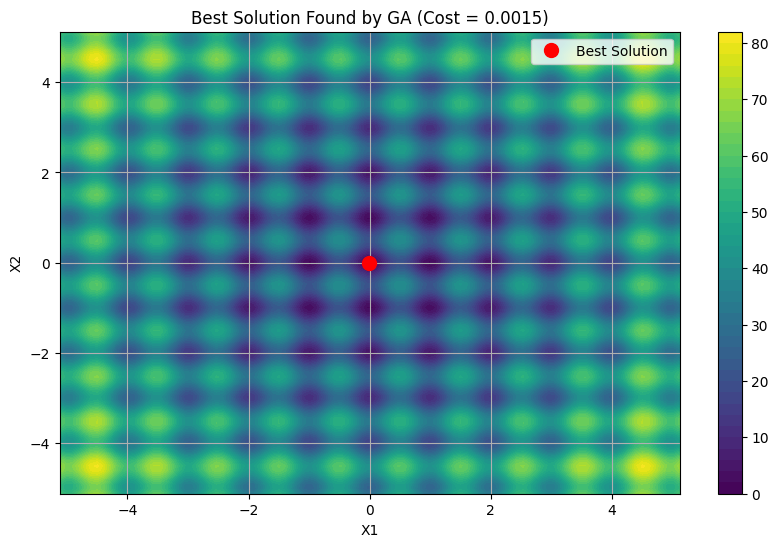

In [262]:
# Plot the best solution found by GA in a 2D plot

def plot_solution_2d_ga(best_solution, best_cost):
    # Get the test function and its parameter ranges
    function, var_min, var_max, var_number = select_test_function(fun_index)
    
    # Convert var_min and var_max to arrays
    var_min = np.array([var_min] * var_number)
    var_max = np.array([var_max] * var_number)
    
    # Set up 2D grid for plotting
    x = np.linspace(var_min[0], var_max[0], 100)
    y = np.linspace(var_min[1], var_max[1], 100)
    X, Y = np.meshgrid(x, y)
    
    # Compute the function values for the grid
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            point = np.array([X[i, j], Y[i, j]])
            Z[i, j] = function(point)
    
    # Plot the function and the best solution
    plt.figure(figsize=(10, 6))
    plt.contourf(X, Y, Z, levels=50, cmap='viridis')
    plt.plot(best_solution[0], best_solution[1], 'ro', markersize=10, label='Best Solution')
    plt.title(f'Best Solution Found by GA (Cost = {best_cost:.4f})')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.colorbar()
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the 2D plotting function for GA
plot_solution_2d_ga(best_solution_ga, best_cost_ga)

## Comparing the metaheuristics

In [302]:
n_runs = 5  # Número de ejecuciones por cada algoritmo
results = {'AOS': [], 'PSO': [], 'GA': []}
times = {'AOS': [], 'PSO': [], 'GA': []}
convergences = {'AOS': {}, 'PSO': {}, 'GA': {}}  # Diccionario de convergencias separado por funciones

# Total de funciones a probar
function_indices = 11

for fun_index in range(1, function_indices + 1):
    function, var_min, var_max, var_number = select_test_function(fun_index)
    function_pso, var_min_pso, var_max_pso, var_number_pso = select_test_function_pso(fun_index)
    print(f"Function {fun_index}: {function.__name__} (Dimension: {var_number})")

    # Optimización de parámetros para AOS
    task_aos = Task(problem=AOSParamOptimization(fun_index), max_evals=50)
    abc_aos = ArtificialBeeColonyAlgorithm(population_size=20)
    best_params_aos, best_cost_aos = abc_aos.run(task=task_aos)

    # Optimización de parámetros para PSO
    task_pso = Task(problem=PSOParamOptimization(fun_index), max_evals=50)
    abc_pso = ArtificialBeeColonyAlgorithm(population_size=20)
    best_params_pso, best_cost_pso = abc_pso.run(task=task_pso)

    # Optimización de parámetros para GA
    task_ga = Task(problem=GAParamOptimization(fun_index), max_evals=50)
    abc_ga = ArtificialBeeColonyAlgorithm(population_size=20)
    best_params_ga, best_cost_ga = abc_ga.run(task=task_ga)

    # Ejecutar cada algoritmo con los parámetros optimizados
    for run in range(n_runs):
        # AOS
        start_time = time.time()
        aos = AtomicOrbitalSearch(
            cost_function=function,
            var_number=var_number,
            var_min=var_min,
            var_max=var_max,
            max_fes=10000,
            n_pop=int(best_params_aos[0]),
            layer_number=int(best_params_aos[1]),
            foton_rate=best_params_aos[2]
        )
        best_pos_aos, best_cost_aos, best_costs_aos = aos.run()
        end_time = time.time()
        results['AOS'].append([best_pos_aos, best_cost_aos])
        times['AOS'].append(end_time - start_time)

        # Almacenar la convergencia de AOS para la función actual
        if fun_index not in convergences['AOS']:
            convergences['AOS'][fun_index] = []
        convergences['AOS'][fun_index].append(best_costs_aos)

        # PSO
        start_time = time.time()
        var_min_array = np.full(var_number, var_min) if np.isscalar(var_min) else np.array(var_min)
        var_max_array = np.full(var_number, var_max) if np.isscalar(var_max) else np.array(var_max)
        optimizer = GlobalBestPSO(n_particles=int(best_params_pso[0]), dimensions=var_number,
                                  options={'c1': best_params_pso[1], 'c2': best_params_pso[2], 'w': best_params_pso[3]},
                                  bounds=(var_min_array, var_max_array))
        best_cost_pso, best_pos_pso = optimizer.optimize(function_pso, iters=100, verbose=False)
        end_time = time.time()
        results['PSO'].append([best_pos_pso, best_cost_pso])
        times['PSO'].append(end_time - start_time)

        # Almacenar la convergencia de PSO para la función actual
        if fun_index not in convergences['PSO']:
            convergences['PSO'][fun_index] = []
        convergences['PSO'][fun_index].append(optimizer.cost_history)

        # GA
        start_time = time.time()
        varbound = np.array([[var_min, var_max]] * var_number)
        algorithm_params = {
            "max_num_iteration": int(best_params_ga[0]),
            "population_size": int(best_params_ga[1]),
            "mutation_probability": best_params_ga[3],
            "elit_ratio": 0.01,
            "crossover_probability": best_params_ga[2],
            "parents_portion": 0.3,
            "crossover_type": "uniform",
            "max_iteration_without_improv": None}
        ga_model = ga(function=function, dimension=var_number, variable_type='real', 
                      variable_boundaries=varbound, algorithm_parameters=algorithm_params, convergence_curve=False, progress_bar=False)
        ga_model.run()
        end_time = time.time()
        best_solution_ga = ga_model.output_dict['variable']
        best_cost_ga = ga_model.output_dict['function']
        results['GA'].append([best_solution_ga, best_cost_ga]) 
        times['GA'].append(end_time - start_time)

        # Almacenar la convergencia de GA para la función actual
        if fun_index not in convergences['GA']:
            convergences['GA'][fun_index] = []
        convergences['GA'][fun_index].append(ga_model.report)


Function 1: function (Dimension: 2)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


 The best solution found:
 [0.46517881 0.19888178]

 Objective function:
 0.25594528239998837
 The best solution found:
 [ 0.16936887 -0.02902911]

 Objective function:
 0.029528504800664393
 The best solution found:
 [ 0.17783496 -0.2815099 ]

 Objective function:
 0.11087309613506517
 The best solution found:
 [-0.123375   -0.99658279]

 Objective function:
 1.008398653128763
 The best solution found:
 [ 0.40390931 -0.24707537]

 Objective function:
 0.2241889695687934
 The best solution found:
 [0.09760648 0.06362885]

 Objective function:
 0.013575655813387516
 The best solution found:
 [-1.98402735 -7.09461713]

 Objective function:
 54.26995671696274
 The best solution found:
 [0.77234656 0.17008786]

 Objective function:
 0.6254490907200054
 The best solution found:
 [-0.06734177  0.00764824]

 Objective function:
 0.004593409480361314
 The best solution found:
 [4.29317732e-04 5.71168034e-01]

 Objective function:
 0.3262331069436988
 The best solution found:
 [ 1.71528227 -0.5

Las convergencias de la función 1 tienen tamaños incompatibles.


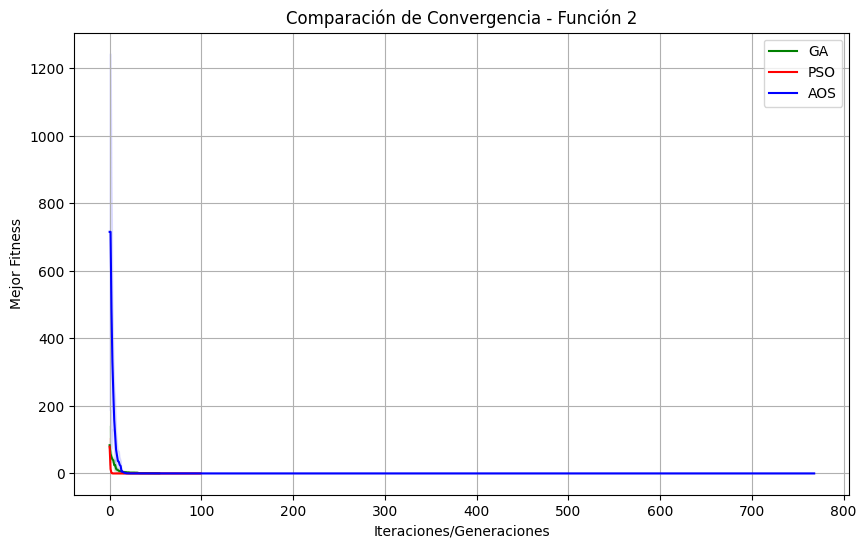

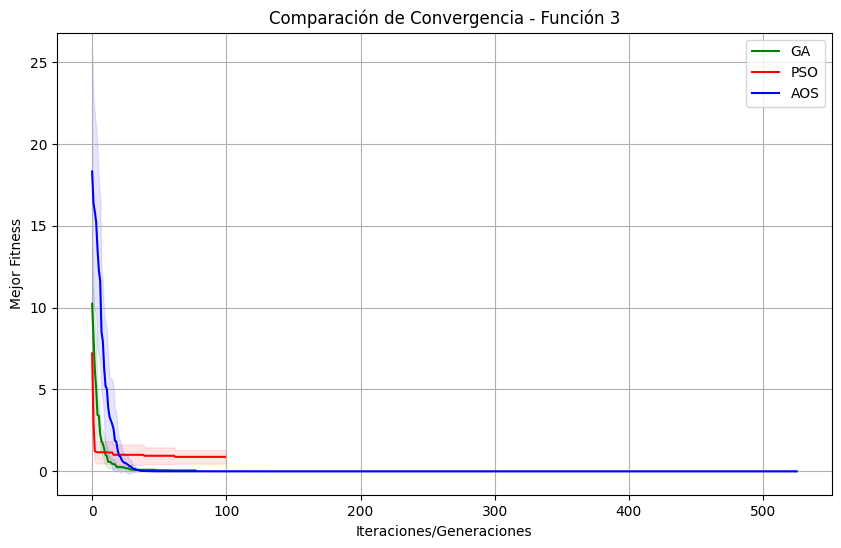

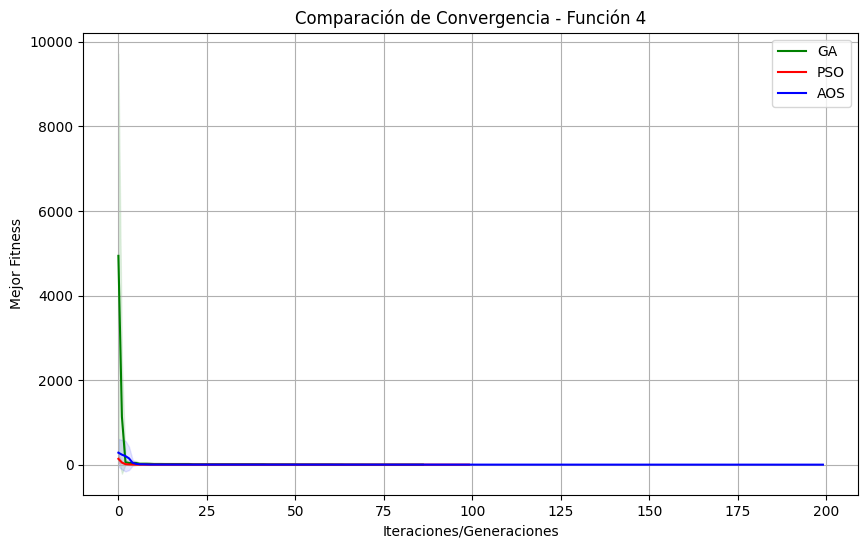

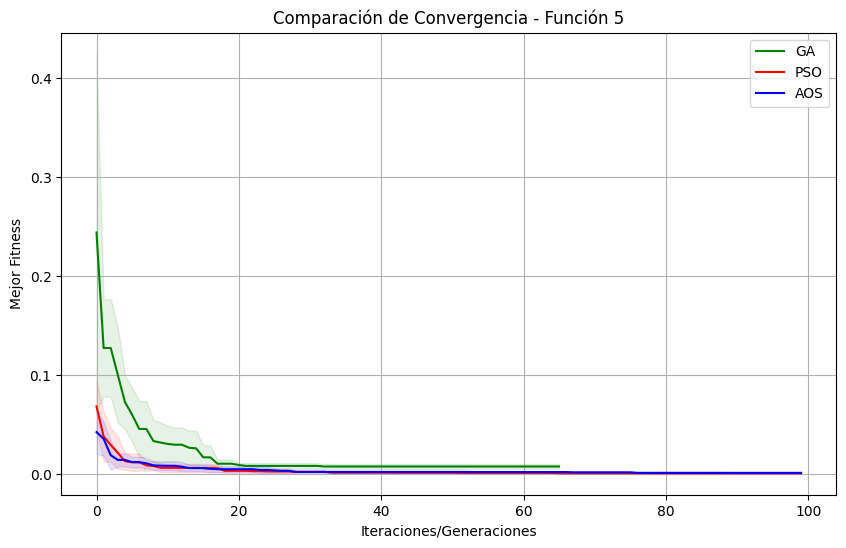

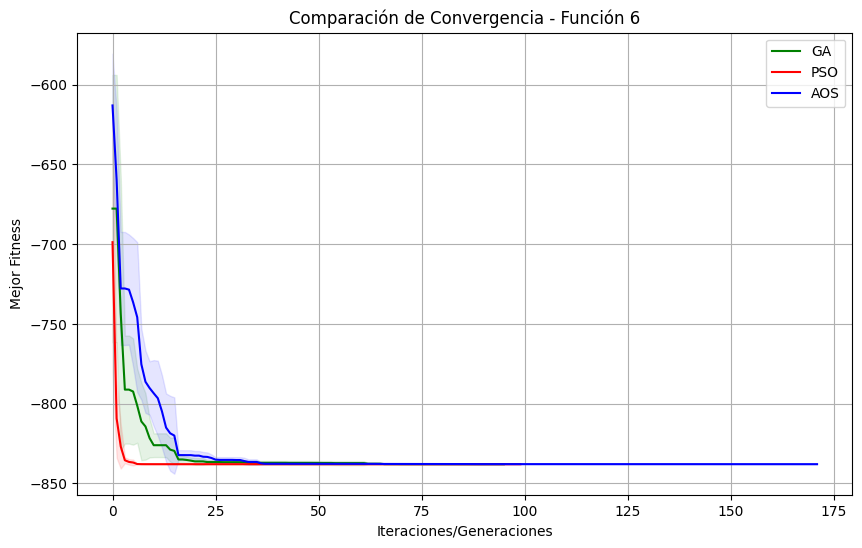

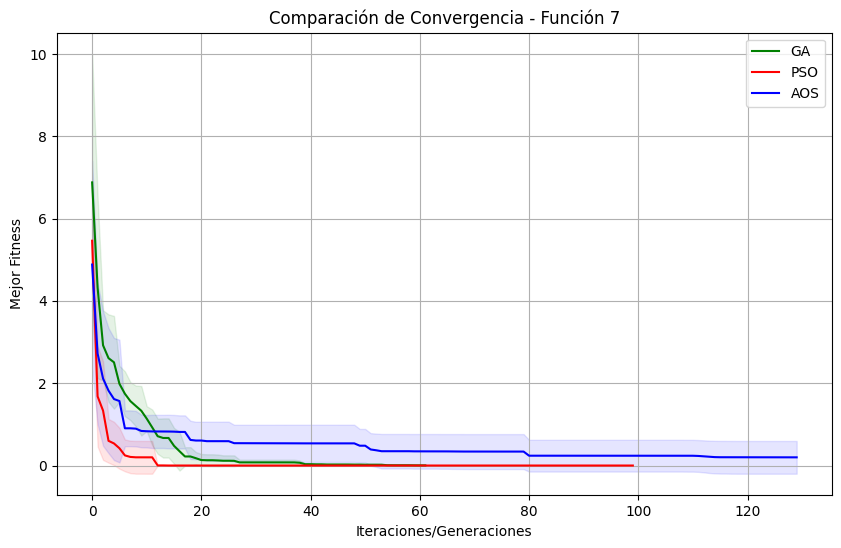

Las convergencias de la función 8 tienen tamaños incompatibles.


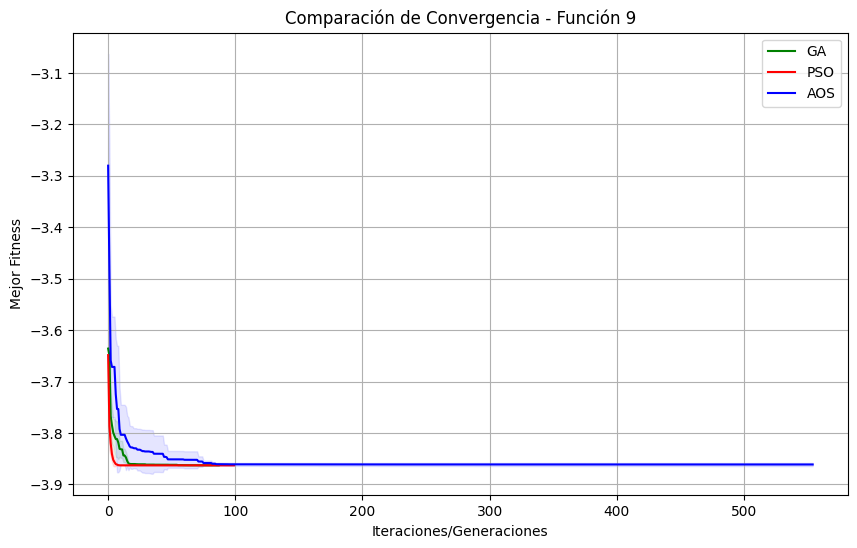

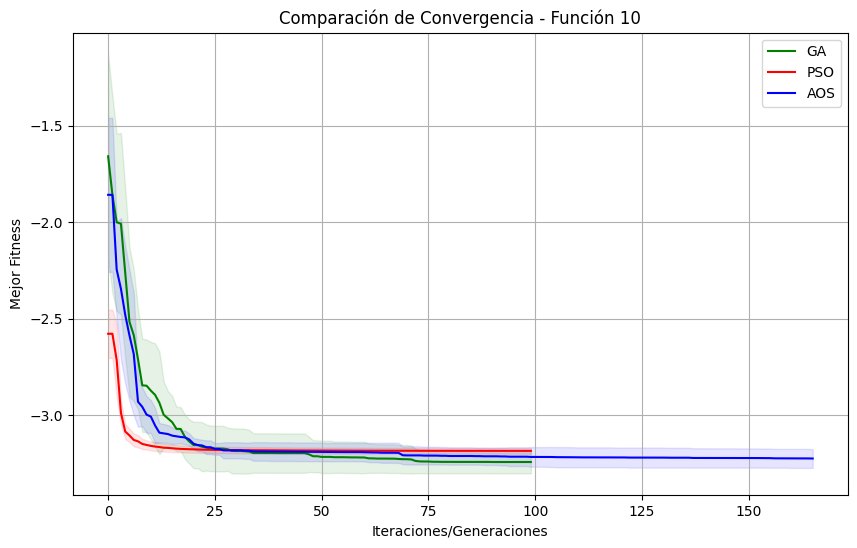

Las convergencias de la función 11 tienen tamaños incompatibles.


In [304]:
import numpy as np
import matplotlib.pyplot as plt

def plot_convergence_for_all_functions(function_indices):
    # Itera sobre todas las funciones
    for fun_index in range(1, function_indices + 1):
        # Obtener las convergencias para esta función de cada algoritmo
        ga_convergence = convergences['GA'].get(fun_index, [])
        pso_convergence = convergences['PSO'].get(fun_index, [])
        aos_convergence = convergences['AOS'].get(fun_index, [])

        # Verificar si las listas están vacías
        if not ga_convergence or not pso_convergence or not aos_convergence:
            print(f"Convergencias no disponibles para la función {fun_index}. Saltando...")
            continue

        # Convertir las listas de convergencia a matrices numpy asegurándonos de que tengan la misma longitud
        try:
            ga_fitness_matrix = np.array(ga_convergence)
            pso_fitness_matrix = np.array(pso_convergence)
            aos_fitness_matrix = np.array(aos_convergence)
        except ValueError:
            print(f"Las convergencias de la función {fun_index} tienen tamaños incompatibles.")
            continue

        # Calcular el promedio y la desviación estándar, si hay convergencias
        ga_mean = np.mean(ga_fitness_matrix, axis=0)
        pso_mean = np.mean(pso_fitness_matrix, axis=0)
        aos_mean = np.mean(aos_fitness_matrix, axis=0)

        ga_std = np.std(ga_fitness_matrix, axis=0)
        pso_std = np.std(pso_fitness_matrix, axis=0)
        aos_std = np.std(aos_fitness_matrix, axis=0)

        # Graficar las curvas de convergencia
        plt.figure(figsize=(10, 6))

        # Curvas de los promedios
        plt.plot(ga_mean, label='GA', color='green')
        plt.plot(pso_mean, label='PSO', color='red')
        plt.plot(aos_mean, label='AOS', color='blue')

        # Bandas de desviación estándar
        plt.fill_between(range(len(ga_mean)), ga_mean - ga_std, ga_mean + ga_std, color='green', alpha=0.1)
        plt.fill_between(range(len(pso_mean)), pso_mean - pso_std, pso_mean + pso_std, color='red', alpha=0.1)
        plt.fill_between(range(len(aos_mean)), aos_mean - aos_std, aos_mean + aos_std, color='blue', alpha=0.1)

        # Etiquetas y título
        plt.xlabel('Iteraciones/Generaciones')
        plt.ylabel('Mejor Fitness')
        plt.title(f'Comparación de Convergencia - Función {fun_index}')
        plt.legend()
        plt.grid(True)
        plt.show()

# Llamar a la función para graficar la convergencia por función
plot_convergence_for_all_functions(function_indices)



In [317]:
import pandas as pd
import numpy as np

# Example: Theoretical optimal solutions for each function (replace with actual values)
optimal_solutions = {
    1: 0.0,  # Sphere Function
    2: 0.0,  # Schwefel 1.2
    3: 0.0,  # Schwefel 2.21
    4: 0.0,  # Rosenbrock (Optimal fitness value is 0.0 for X=1)
    5: 0.0,  # Quartic Function with Noise (ignoring noise)
    6: -418.9829*2,  # Schwefel Function (dimension-dependent, replace `n` with the dimension)
    7: 0.0,  # Rastrigin Function
    8: 0.0,  # Ackley Function
    9: -3.86278,  # Hartman 3
    10: -3.32237,  # Hartman 6
    11: -10.536  # Shekel Function (Shekel 10)
}

# Placeholder for the table data
table_data = []

# Tolerance for determining whether a solution is optimal
tolerance = 1e-2

for fun_index in range(1, function_indices + 1):
    optimal_solution = optimal_solutions[fun_index]
    row = {"Function": fun_index}

    for algorithm in ['GA', 'PSO', 'AOS']:
        # Get results and times for the current function
        func_results = results[algorithm][(fun_index - 1) * n_runs: fun_index * n_runs]
        func_times = times[algorithm][(fun_index - 1) * n_runs: fun_index * n_runs]

        # Count how many times the optimal solution is found
        optimal_count = sum(1 for result in func_results if abs(result[1] - optimal_solution) <= tolerance)

        # Compute mean time, mean fitness, and best fitness
        mean_time = np.mean(func_times)
        mean_fitness = np.mean([result[1] for result in func_results])
        best_fitness = np.min([result[1] for result in func_results])

        # Add algorithm details to the row
        row[f"{algorithm}_MeanTime"] = round(mean_time, 4)
        row[f"{algorithm}_MeanFitness"] = round(mean_fitness, 4)
        row[f"{algorithm}_BestFitness"] = round(best_fitness, 4)
        row[f"{algorithm}_OptimalCount"] = optimal_count

    table_data.append(row)

# Create a DataFrame for display
columns = ["Function", 
           "GA_MeanTime", "GA_MeanFitness", "GA_BestFitness", "GA_OptimalCount",
           "PSO_MeanTime", "PSO_MeanFitness", "PSO_BestFitness", "PSO_OptimalCount",
           "AOS_MeanTime", "AOS_MeanFitness", "AOS_BestFitness", "AOS_OptimalCount"]

df = pd.DataFrame(table_data, columns=columns)

# Save the results to a CSV file
df.to_csv('results.csv', index=False)


In [318]:
df

Function  GA_MeanTime  GA_MeanFitness  GA_BestFitness  GA_OptimalCount  \
0          1       0.5760          0.0771          0.0105                0   
1          2       0.5540          0.4763          0.0094                1   
2          3       1.7619          0.0548          0.0098                1   
3          4       0.3323          1.0459          0.0875                0   
4          5       0.1482          0.0075          0.0040                4   
5          6       0.6570       -837.9567       -837.9639                3   
6          7       0.5291          0.0035          0.0004                5   
7          8       0.6884          0.0298          0.0072                2   
8          9       0.6607         -3.8626         -3.8627                5   
9         10       0.5854         -3.2424         -3.3208                1   
10        11       0.8808        -10.4416        -10.4954                0   

    PSO_MeanTime  PSO_MeanFitness  PSO_BestFitness  PSO_OptimalCount  \
0         0.0197           0.0000           0.0000                 5   
1         0.1892           0.0000           0.0000                 5   
2         0.0387           0.8837           0.2475                 0   
3         0.0243           0.0000           0.0000                 5   
4         0.0216           0.0006           0.0001                 5   
5         0.0218        -837.9658        -837.9658                 5   
6         0.0206           0.0000           0.0000                 5   
7         0.0261           0.0000           0.0000                 5   
8         0.7820          -3.8628          -3.8628                 5   
9         0.6847          -3.1846          -3.2030                 0   
10        1.0796          -5.9503         -10.5364                 2   

    AOS_MeanTime  AOS_MeanFitness  AOS_BestFitness  AOS_OptimalCount  
0         0.5362           0.0000           0.0000                 5  
1         0.4725           0.0000           0.0000                 5  
2         0.7681           0.0000           0.0000                 5  
3         0.4488           0.0000           0.0000                 5  
4         0.3869           0.0011           0.0002                 5  
5         0.4258        -837.9589        -837.9634                 4  
6         0.3939           0.1990           0.0000                 4  
7         0.5324           0.0000           0.0000                 5  
8         0.9102          -3.8612          -3.8628                 5  
9         0.8226          -3.2243          -3.3215                 1  
10        1.1907          -9.0561         -10.5201                 0

In [320]:
# Calculate avg time for each algorithm
avg_times = {algorithm: np.mean(times[algorithm]) for algorithm in times}
avg_times

# Calculate avg count of optimal solutions for each algorithm
optimal_counts = {algorithm: sum(row[f"{algorithm}_OptimalCount"] for row in table_data) for algorithm in ['GA', 'PSO', 'AOS']}
optimal_counts

{'GA': 22, 'PSO': 42, 'AOS': 44}

/var/folders/k8/pm7rdrpx1tx44znvg04hlryc0000gn/T/ipykernel_21243/614254345.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(padded_results.values(), labels=padded_results.keys())


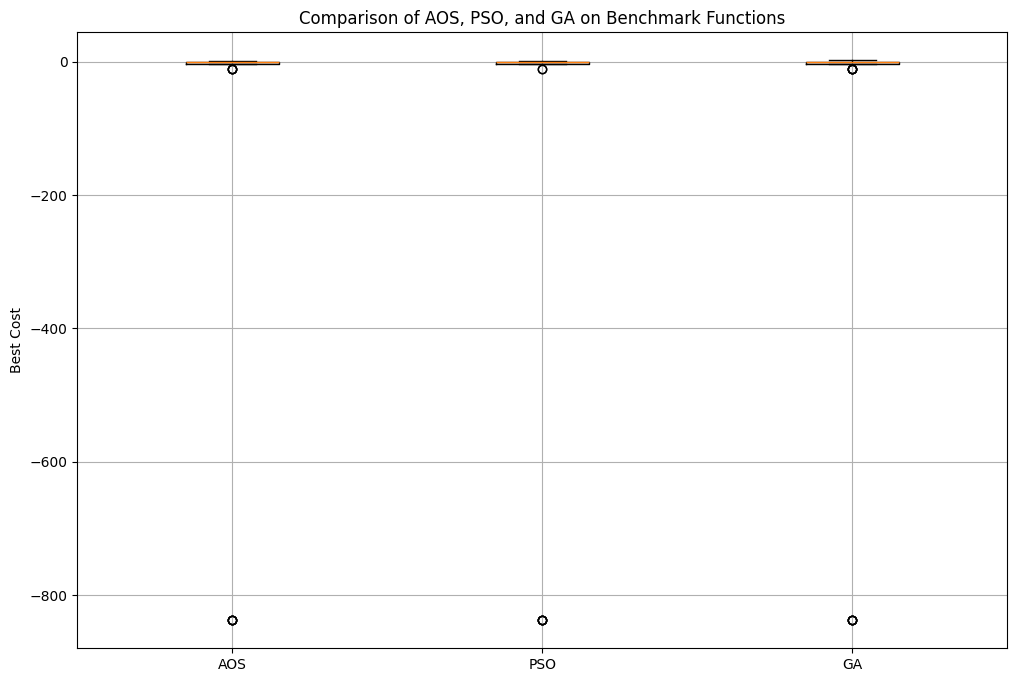

In [312]:
import numpy as np
import matplotlib.pyplot as plt

# Extraer solo los mejores costos de los resultados
best_costs_aos = [result[1] for result in results['AOS']]  # Asegurarse de tomar solo el mejor costo
best_costs_pso = [result[1] for result in results['PSO']]  # Lo mismo para PSO
best_costs_ga = [result[1] for result in results['GA']]  # Y para GA

# Determinar la longitud máxima entre los resultados
max_length = max(len(best_costs_aos), len(best_costs_pso), len(best_costs_ga))

# Rellenar las listas con None si tienen longitud menor que la máxima
best_costs_aos += [None] * (max_length - len(best_costs_aos))
best_costs_pso += [None] * (max_length - len(best_costs_pso))
best_costs_ga += [None] * (max_length - len(best_costs_ga))

# Crear un diccionario con las listas de los mejores costos
padded_results = {
    'AOS': best_costs_aos,
    'PSO': best_costs_pso,
    'GA': best_costs_ga
}

# Graficar los resultados con boxplot
plt.figure(figsize=(12, 8))
plt.boxplot(padded_results.values(), labels=padded_results.keys())
plt.ylabel('Best Cost')
plt.title('Comparison of AOS, PSO, and GA on Benchmark Functions')
plt.grid(True)
plt.show()


### Statistical Analysis

#### Friedman Test

In [322]:
from scipy.stats import friedmanchisquare

# Perform the Friedman test
statistic, p_value = friedmanchisquare(best_costs_aos, best_costs_pso, best_costs_ga)
statistic, p_value

(30.542056074766275, 2.3327961526163962e-07)

#### Nemenyi Test

In [333]:
import scikit_posthocs as sp

# Perform the post-hoc Nemenyi test
data = np.array([best_costs_aos, best_costs_pso, best_costs_ga])
posthhoc = sp.posthoc_nemenyi_friedman(data.T)

print(posthhoc)

          0         1         2
0  1.000000  0.995001  0.000006
1  0.995001  1.000000  0.000009
2  0.000006  0.000009  1.000000
